In [0]:
!unzip titanic.zip

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (roc_curve, auc, accuracy_score)

In [0]:
'''
サンプルの生成
'''
train = pd.read_csv("train.csv")      # (891, 12)
test = pd.read_csv("test.csv")        # (418, 11)

train_len = len(train)      # 891
test_len = len(test)        # 418

In [0]:
'''
データの前処理
'''
def missing_table(df):      # データの欠損を計算
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    missing_table_ren_columns = missing_table.rename(
        columns = {0:"欠損数", 1:"%"}
    )
    return missing_table_ren_columns

# missing_table(train)
# print(missing_table(test))

# 欠損の穴埋め
train["Age"] = train["Age"].fillna(train["Age"].median())
train["Embarked"] = train["Embarked"].fillna("S")
train["Sex"][train["Sex"]=="male"] = 0
train["Sex"][train["Sex"]=="female"] = 1
train["Embarked"][train["Embarked"]=="S"] = 0
train["Embarked"][train["Embarked"]=="C"] = 1
train["Embarked"][train["Embarked"]=="Q"] = 2

test["Age"] = test["Age"].fillna(test["Age"].median())
test["Sex"][test["Sex"]=="male"] = 0
test["Sex"][test["Sex"]=="female"] = 1
test["Embarked"][test["Embarked"]=="S"] = 0
test["Embarked"][test["Embarked"]=="C"] = 1
test["Embarked"][test["Embarked"]=="Q"] = 2
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

train["Sex"] = pd.to_numeric(train["Sex"], errors='coerce')
train["Embarked"] = pd.to_numeric(train["Embarked"], errors='coerce')
test["Sex"] = pd.to_numeric(test["Sex"], errors='coerce')
test["Embarked"] = pd.to_numeric(test["Embarked"], errors='coerce')

In [0]:
# 一人かどうか
alone_train = np.zeros((train_len))
for i in range(train_len):
    if train["Parch"][i].all()==0 and train["SibSp"][i].all()==0:
        alone_train[i] = 1
alone_test = np.zeros((test_len))
for i in range(test_len):
    if test["Parch"][i].all()==0 and test["SibSp"][i].all()==0:
        alone_test[i] = 1

list_alone_train = list(alone_train.astype(int))
pd_alone_train = pd.DataFrame({'Alone':alone_train})
train = pd.concat([train.reset_index(drop=True), pd_alone_train.reset_index(drop=True)], axis=1)
list_alone_test = list(alone_test.astype(int))
pd_alone_test = pd.DataFrame({'Alone':alone_test})
test = pd.concat([test.reset_index(drop=True), pd_alone_test.reset_index(drop=True)], axis=1)

In [0]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corrmat, vmax=.8, annot = True, center = 0)

In [0]:
# n_train = 791
val_ratio = 0.3
f_name = 'model_titanic_trained.h5'
# f_name = 'model_titanic_tset.h5'

In [0]:
'''
入力の生成
'''
train_dropped = train.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1)
train_x = train_dropped.drop('Survived', axis=1)
train_y = train_dropped.Survived


In [0]:
submit_dropped = test.drop(['Cabin', 'Name', 'PassengerId', 'Ticket'], axis=1)
submit_x = submit_dropped

(train_x, val_x, train_y, val_y) = train_test_split(train_x, train_y, test_size=val_ratio, random_state=666)       # random_stateのseedを適当に固定

In [0]:
'''
モデルの生成
'''
model = DecisionTreeClassifier(random_state=0)

In [0]:
'''
学習
'''
model = model.fit(train_x, train_y)

In [184]:
'''
評価
'''
pred = model.predict(val_x)
fpr, tpr, thresholds = roc_curve(val_y, pred, pos_label=1)
print("AUC:",auc(fpr, tpr))
print("Accuracy:",accuracy_score(pred, val_y))

AUC: 0.79582828457677
Accuracy: 0.8022388059701493


In [185]:
'''
提出
'''
# submit_model = model.fit(train_x, train_y)
submit = submit_model.predict(submit_x)
submit = np.round(submit).astype(int)
submit = submit.flatten()
submit[:10]

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0])

In [0]:
# PassengerIdを取得
PassengerId = np.array(test["PassengerId"]).astype(int)
 
# my_prediction(予測データ）とPassengerIdをデータフレームへ落とし込む
my_solution = pd.DataFrame(submit, PassengerId, columns = ["Survived"])
 
# my_tree_one.csvとして書き出し
my_solution.to_csv("nn.csv", index_label = ["PassengerId"])

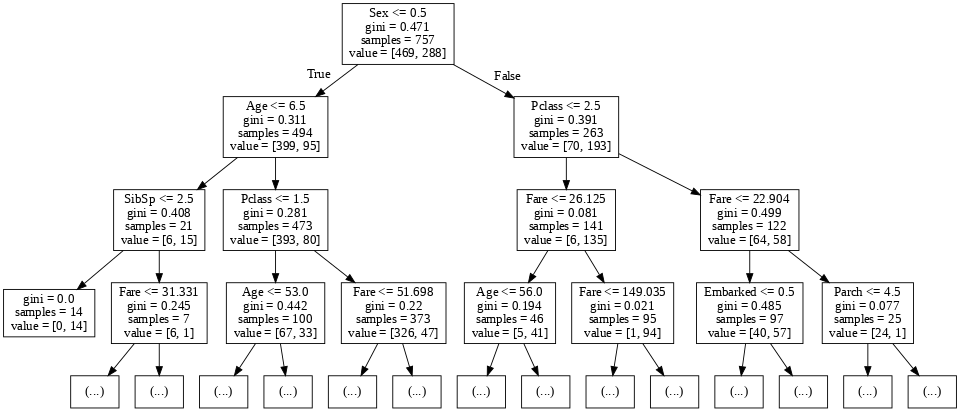

In [53]:
'''
木構造の可視化
'''
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn.externals.six import StringIO
from sklearn import tree

dot_data = StringIO()
tree.export_graphviz(model, out_file=dot_data,feature_names=train_x.columns, max_depth=3)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
graph.write_pdf("graph_DTC.pdf")
graph.set_size('"10,5!"')
Image(graph.create_png())